## Boom Bikes Multiple Linear Regression
### Introduction: 
Boob Bikes is a US bike-sharing provider in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.
### Problem Statement: 
The company whats to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

### 1. Reading & understanding of data

In [2]:
data = pd.read_csv('day.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# Checking the shape
data.shape

(730, 16)

In [4]:
# Missing Value checks
data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
# Dropping the duplicates if any
data.drop_duplicates(inplace=True)
data.shape

(730, 16)

In [6]:
#Data type checks for all columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 97.0+ KB


### 2. Treating Categorical columns

***Understanding the Binary Features:***

*1. holiday :* 
- 1 - Holiday
- 0 - Not a Holiday 

*2. yr :*
- 1 - Represents 2019
- 0 - Represents 2018

*3. workingday :*
- 1 - If day is neither weekend nor holiday is 1
- 0 - Either weekend or holiday

From the data dictionary we get to know that `0` indicates either `weekend or holiday` we checked the day for the first entry that is `01-01-2018`

In [7]:
# Getting the exact day on 01-01-2018
date ='01-01-2018'
day = datetime.datetime.strptime(date, '%d-%m-%Y').weekday()
print(calendar.day_name[day])

Monday


But for the first record dated `01-01-2018` we see the column `weekday` represents `6` which means its `Saturday` as per Data Dictionary. We could also find some pattern that is `5 1's & 2 0's` in the column `workingday` which means 5 weekdays and 2 weekends. This pattern is continous through out the data. 
- Now we got into a confusion, Do we need map the first day as Monday or Saturday?

In [8]:
# Checking for refernce before directly mapping
data.head(15)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959
8,9,09-01-2018,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,54,768,822
9,10,10-01-2018,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321


For now to avoid confusion and proceed with the modelling lets ignore the day calculated manually and map as per the Data dictionary

In [9]:
# Creating dictionary to map values
seasons = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
weathers = {1:'Clear', 2:'Mist', 3:'Light Snow', 4:'Heavy Rain'}
weekdays = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

In [10]:
# Mapping categorical variables from Data dictonary.
data['season'] = data['season'].map(seasons)
data['mnth'] = data['mnth'].map(months)
data['weathersit'] = data['weathersit'].map(weathers)
data['weekday'] = data['weekday'].map(weekdays)

In [11]:
# Now lets look our data before getting into the EDA process
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,Spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,Spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,Spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,Spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,Spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### 3. EDA - Visualizing the data

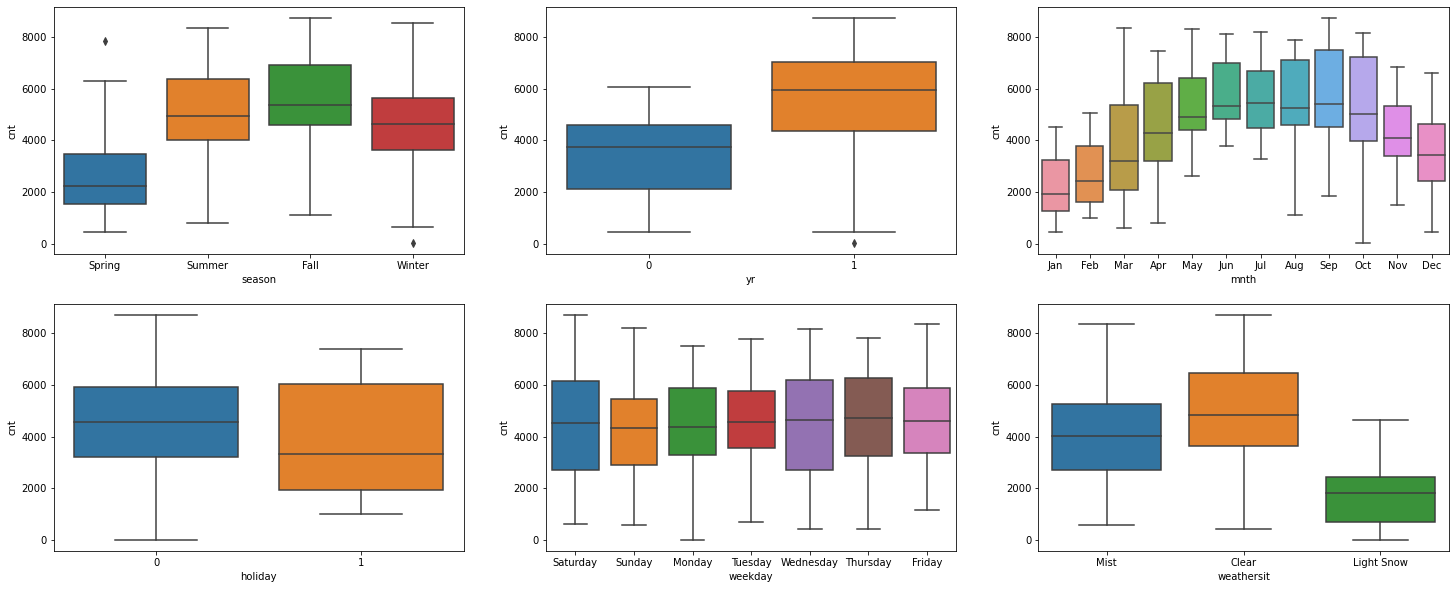

In [12]:
plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = data)
plt.subplot(2,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = data)
plt.subplot(2,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = data)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = data)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = data)
plt.subplot(2,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = data)
plt.show()

Insight:
- The use of bikes is more in Fall season & during springs its very minimal
- Septemper month has been witnessed a huge demand for shared bikes
- On an average the use of bikes is less during holidays
- The use of shared bikes is more while the weather is clear & We have also seen that there is no use of bike in heavy rains

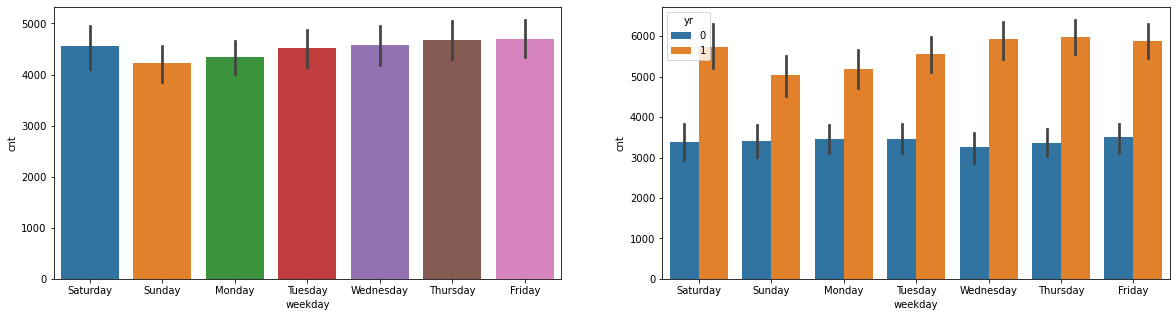

In [13]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.barplot(x = 'weekday', y = 'cnt', data = data)
plt.subplot(1,2,2)
sns.barplot(x = 'weekday', y = 'cnt', data = data, hue='yr')
plt.show()

Insight:
- We can say that the demand for bikes is quite more for Thursday, Friday & Saturday

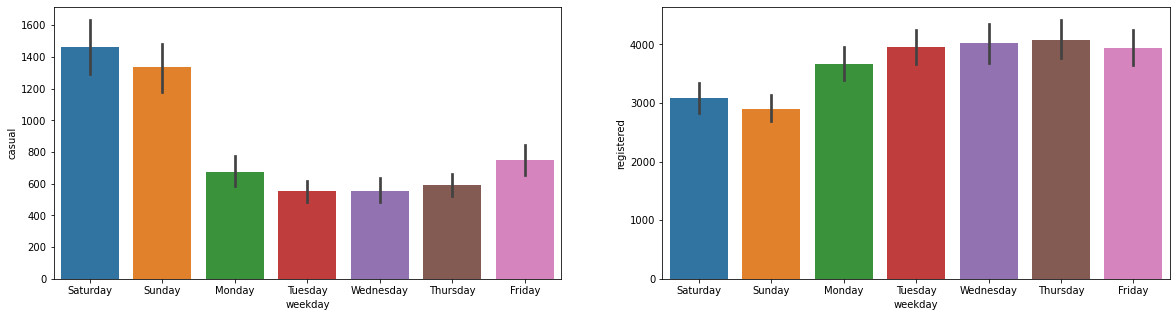

In [14]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.barplot(x = 'weekday', y = 'casual', data = data)
plt.subplot(1,2,2)
sns.barplot(x = 'weekday', y = 'registered', data = data)
plt.show()

Insight:
- Most of casual users rent the bikes during the weekends whereas the registered user use it during the weekdays

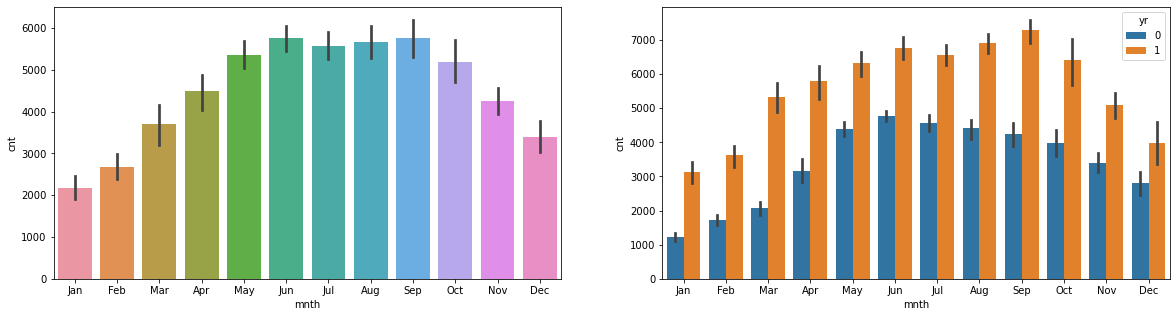

In [15]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.barplot(x = 'mnth', y = 'cnt', data = data)
plt.subplot(1,2,2)
sns.barplot(x = 'mnth', y = 'cnt', data = data, hue='yr')
plt.show()

Insight:
- June to September is where many of the people rent the bikes and the demand goes gradually downwards

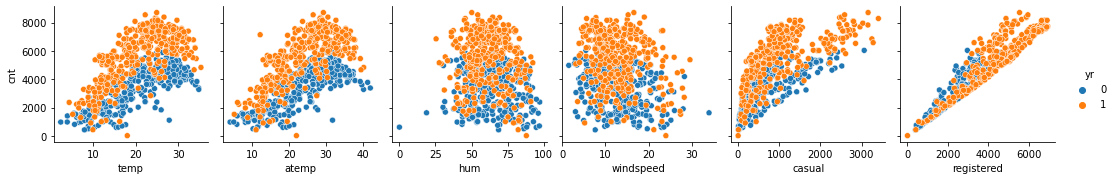

In [16]:
sns.pairplot(x_vars=['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'], y_vars='cnt', data=data, hue='yr')

Insight:
- All the parameters have increased values in 2019 compared to 2018. Thus, year may become a key paratemeter in the model

<AxesSubplot:>

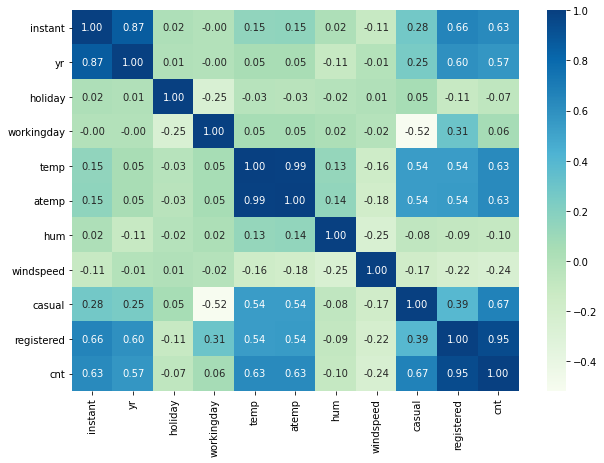

In [17]:
plt.figure(figsize = (10, 7))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='GnBu')

Insight:
- Temp & Atemp has positive corelation with respect to the bussines therefore while feeding it to ML we need to drop any one
- Year has positive impact for increasing of bike rentals
- No registerd users have increased by 60% over the year
- Humidty & Windspeed has a negative impact on the bike rentals

### 4. Data Prepartion for ML

In [18]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,Spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,Spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,Spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,Spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,Spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##### Now we will convert all the variable having some levels or indicating some categories by using dummy variables.

In [19]:
# Treating season column
season = pd.get_dummies(data['season'], drop_first=True)
season.sample(4)

,Spring,Summer,Winter
180,0,0,0
522,0,1,0
335,0,0,1
128,0,1,0


Now, we don't need all 4 columns in the data. We dropped `fall`, as `fall` can be identified if rest of the 3 colums are 0
- `000` will correspond to `fall`
- `100` will correspond to `spring`
- `010` will correspond to `summer`
- `001` will correspond to `winter`

While using the `drop_first=True` parameter, its drops the variable based on Alphatic order. 
Therefore in graph we see season `Fall` had more rentals and its better we try to keep this into our model.
Similarlly it follows for all the categorical variables so we'll drop it manually at the end.

In [20]:
# Treating season column
season = pd.get_dummies(data['season'])
season.sample(4)

,Fall,Spring,Summer,Winter
339,0,0,0,1
385,0,1,0,0
517,0,0,1,0
482,0,0,1,0


In [21]:
# Treating month column
month = pd.get_dummies(data['mnth'])
month.sample(4)

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
372,0,0,0,0,1,0,0,0,0,0,0,0
93,1,0,0,0,0,0,0,0,0,0,0,0
675,0,0,0,0,0,0,0,0,0,1,0,0
345,0,0,1,0,0,0,0,0,0,0,0,0


In [22]:
# Treating weekday column
weekday = pd.get_dummies(data['weekday'])
weekday.sample(4)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
303,0,1,0,0,0,0,0
446,1,0,0,0,0,0,0
72,0,1,0,0,0,0,0
679,0,0,0,1,0,0,0


In [23]:
# Treating weather column
weather = pd.get_dummies(data['weathersit'])
weather.sample(4)

,Clear,Light Snow,Mist
190,1,0,0
143,0,0,1
267,0,0,1
315,1,0,0


In [24]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,Spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,Spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,Spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,Spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,Spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [25]:
# Adding all the columns to the data
data = pd.concat([data, season, month, weekday, weather], axis=1)
data.shape

(730, 42)

In [26]:
# Dropping unwanted column from the data before feeding it to machine learning
data.drop(columns=['instant', 'dteday', 'season', 'Spring', 'mnth', 'Jan', 'weekday', 'Sunday', 'weathersit', 'Light Snow', 
                   'casual', 'registered'], inplace=True)

Explaning dropped variable
- `instant` is just the index of the data
- `dteday` as day, month & year is already extracted we dont need it anymore
- `season` we have created dummy variables & dropping `Spring` as it may cause multicolinearity in the data 
- `mnth` we have created dummy variables & dropping `Jan` as it may cause multicolinearity in the data 
- `weekday` we have created dummy variables & dropping `Sunday` as it may cause multicolinearity in the data 
- `weathersit` we have created dummy variables & dropping `Light Snow` as it may cause multicolinearity in the data 
- `casual` and `registered` as our main focus is to predict the overall retals ie `cnt`

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   hum         730 non-null    float64
 6   windspeed   730 non-null    float64
 7   cnt         730 non-null    int64  
 8   Fall        730 non-null    uint8  
 9   Summer      730 non-null    uint8  
 10  Winter      730 non-null    uint8  
 11  Apr         730 non-null    uint8  
 12  Aug         730 non-null    uint8  
 13  Dec         730 non-null    uint8  
 14  Feb         730 non-null    uint8  
 15  Jul         730 non-null    uint8  
 16  Jun         730 non-null    uint8  
 17  Mar         730 non-null    uint8  
 18  May         730 non-null    uint8  
 19  Nov         730 non-null    u

### 5. Splitting Train & Test

In [28]:
# Copying data so that we dont loose the final dataset
model_data = data

In [29]:
# Splitting the data into train & test dataset 
data_train, data_test = train_test_split(model_data, train_size = 0.75, random_state = 42)

In [30]:
data_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Fall,Summer,...,Oct,Sep,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,Clear,Mist
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,...,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,0.517367,0.029250,0.674589,20.553348,24.014576,63.513846,12.540885,4550.241316,0.263254,0.252285,...,0.091408,0.087751,0.131627,0.148080,0.142596,0.146252,0.135283,0.142596,0.625229,0.343693
std,0.500156,0.168662,0.468957,7.465358,8.084690,14.143274,4.962407,1941.453615,0.440802,0.434722,...,0.288452,0.283192,0.338394,0.355505,0.349980,0.353682,0.342339,0.349980,0.484507,0.475375
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,431.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.096723,17.455200,52.598700,9.000478,3269.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,21.320000,25.378950,63.833300,11.708518,4585.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,26.923347,30.540225,73.510000,15.458575,6037.500000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.041700,28.250014,8714.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# Rescaling using MinMaxCcaler
scaler = MinMaxScaler()

In [32]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
numeric_vars = ['temp','atemp','hum','windspeed','cnt']
data_train[numeric_vars] = scaler.fit_transform(data_train[numeric_vars])

In [33]:
data_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Fall,Summer,...,Oct,Sep,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,Clear,Mist
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,...,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,0.517367,0.029250,0.674589,0.550966,0.526658,0.654501,0.412738,0.497313,0.263254,0.252285,...,0.091408,0.087751,0.131627,0.148080,0.142596,0.146252,0.135283,0.142596,0.625229,0.343693
std,0.500156,0.168662,0.468957,0.226883,0.212245,0.145744,0.185512,0.234390,0.440802,0.434722,...,0.288452,0.283192,0.338394,0.355505,0.349980,0.353682,0.342339,0.349980,0.484507,0.475375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354740,0.354457,0.542022,0.280385,0.342690,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.574266,0.562476,0.657792,0.381621,0.501509,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.744560,0.697974,0.757509,0.521811,0.676868,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 6. Model Building

In [34]:
# Splitting data into x_train & y_train
y_train = data_train.pop('cnt')
x_train = data_train

Since there are 29 indipendent variable in the x_train, manually selecting/dropping input variable will be too time consuming.
- First we'll select features from RFE (Recursive Feature Elimination)
- Manually look the results using VIF & P-values

In [35]:
# Running RFE with the output number of the variable equal to 15
lr = LinearRegression()
lr.fit(x_train, y_train)
rfe = RFE(lr, 15)
rfe = rfe.fit(x_train, y_train)

In [36]:
# Checking which parameters have been selected in that list of 15
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 3),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Fall', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Apr', False, 11),
 ('Aug', False, 14),
 ('Dec', True, 1),
 ('Feb', False, 10),
 ('Jul', True, 1),
 ('Jun', False, 7),
 ('Mar', False, 4),
 ('May', False, 6),
 ('Nov', True, 1),
 ('Oct', False, 5),
 ('Sep', True, 1),
 ('Friday', False, 12),
 ('Monday', False, 8),
 ('Saturday', False, 2),
 ('Thursday', False, 15),
 ('Tuesday', False, 9),
 ('Wednesday', False, 13),
 ('Clear', True, 1),
 ('Mist', True, 1)]

In [37]:
# Getting all the selected features from RFE
features = x_train.columns[rfe.support_]
features

Index(['yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Fall', 'Summer',
       'Winter', 'Dec', 'Jul', 'Nov', 'Sep', 'Clear', 'Mist'],
      dtype='object')

In [38]:
# Creating x_train with RFE selected variables
x_train_rfe = x_train[features]

In [39]:
# Adding constant, fitting the model & observing the result
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     186.5
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          2.37e-200
Time:                        19:37:05   Log-Likelihood:                 519.96
No. Observations:                 547   AIC:                            -1008.
Df Residuals:                     531   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0234      0.045     -0.516      0.6

,Features,VIF
3,atemp,1298.62
2,temp,1277.92
4,hum,18.19
13,Clear,10.75
6,Fall,7.98
14,Mist,7.68
5,windspeed,5.73
8,Winter,4.17
7,Summer,4.05
0,yr,2.11


In [40]:
# Dropping variables
x_train_rfe.drop(columns=['atemp'], inplace=True)
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     199.4
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          3.97e-201
Time:                        19:37:05   Log-Likelihood:                 519.05
No. Observations:                 547   AIC:                            -1008.
Df Residuals:                     532   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0248      0.045     -0.546      0.5

,Features,VIF
2,temp,27.86
3,hum,17.73
12,Clear,10.36
5,Fall,7.93
13,Mist,7.57
4,windspeed,5.12
7,Winter,4.14
6,Summer,4.03
0,yr,2.10
10,Nov,1.98


In [41]:
# Dropping variables
x_train_rfe.drop(columns=['hum'], inplace=True)
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     206.2
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          3.50e-198
Time:                        19:37:05   Log-Likelihood:                 509.28
No. Observations:                 547   AIC:                            -990.6
Df Residuals:                     533   BIC:                            -930.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1747      0.031     -5.704      0.0

,Features,VIF
2,temp,23.83
11,Clear,8.69
4,Fall,7.78
12,Mist,5.19
3,windspeed,4.93
6,Winter,4.12
5,Summer,4.00
0,yr,2.10
9,Nov,1.97
8,Jul,1.84


In [42]:
# Dropping variables
x_train_rfe.drop(columns=['Mist'], inplace=True)
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     199.2
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          2.87e-188
Time:                        19:37:05   Log-Likelihood:                 483.00
No. Observations:                 547   AIC:                            -940.0
Df Residuals:                     534   BIC:                            -884.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.021     -0.141      0.8

,Features,VIF
2,temp,17.36
4,Fall,7.46
6,Winter,4.11
5,Summer,3.94
3,windspeed,3.91
11,Clear,2.56
0,yr,2.02
9,Nov,1.93
8,Jul,1.83
10,Sep,1.50


In [43]:
# Dropping variables
x_train_rfe.drop(columns=['Jul'], inplace=True)
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     214.4
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          5.41e-188
Time:                        19:37:05   Log-Likelihood:                 479.56
No. Observations:                 547   AIC:                            -935.1
Df Residuals:                     535   BIC:                            -883.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.021      0.076      0.9

,Features,VIF
2,temp,17.06
4,Fall,6.99
6,Winter,4.10
5,Summer,3.90
3,windspeed,3.87
10,Clear,2.56
0,yr,2.02
8,Nov,1.93
9,Sep,1.31
7,Dec,1.30


In [44]:
# Dropping variables
x_train_rfe.drop(columns=['Fall'], inplace=True)
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     224.7
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          1.92e-184
Time:                        19:37:05   Log-Likelihood:                 468.36
No. Observations:                 547   AIC:                            -914.7
Df Residuals:                     536   BIC:                            -867.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0243      0.020     -1.195      0.2

,Features,VIF
2,temp,4.75
3,windspeed,3.71
9,Clear,2.54
5,Winter,2.30
0,yr,1.99
7,Nov,1.84
4,Summer,1.62
6,Dec,1.30
8,Sep,1.23
1,holiday,1.04


In [45]:
# Dropping variables
x_train_rfe.drop(columns=['Nov'], inplace=True)
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     246.5
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          2.63e-184
Time:                        19:37:05   Log-Likelihood:                 465.19
No. Observations:                 547   AIC:                            -910.4
Df Residuals:                     537   BIC:                            -867.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0296      0.020     -1.454      0.1

,Features,VIF
2,temp,4.66
3,windspeed,3.67
8,Clear,2.50
0,yr,1.99
4,Summer,1.62
5,Winter,1.46
7,Sep,1.22
6,Dec,1.17
1,holiday,1.04


In [46]:
# Dropping variables
x_train_rfe.drop(columns=['Dec'], inplace=True)
x_train_lm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_lm).fit()
print(lr.summary())

# Calculate the VIFs for this model
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     273.7
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          3.95e-184
Time:                        19:37:05   Log-Likelihood:                 461.88
No. Observations:                 547   AIC:                            -905.8
Df Residuals:                     538   BIC:                            -867.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0420      0.020     -2.115      0.0

,Features,VIF
2,temp,4.64
3,windspeed,3.62
7,Clear,2.50
0,yr,1.97
4,Summer,1.61
5,Winter,1.37
6,Sep,1.21
1,holiday,1.04


Now that we have all the VIF values below 5 & good p-values, lets finalize this model

### 7. Model Interpretation

- *Hypothesis Testing:* Since all our coefficients are not equal to zero, which means we Reject Null Hypothesis.
- *F-Statistics:* The F-Statistics value of `273.7` (which is greater than 1) and the p-value of `~0.0000` states that the overall model is significant.

### 8. Residual Analysis 
- Linear Relationship
- Normality of Errors
- Homoscedasticity
- Independence of residuals
- Absence of Multicollinearity

In [47]:
y_train_pred = lr.predict(x_train_lm)
error = y_train - y_train_pred

***8.1 - Linear Relationship***

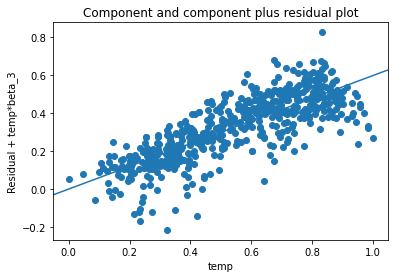

In [48]:
# A partial residual plot
sm.graphics.plot_ccpr(lr, 'temp')
plt.show()

A partial residual plot is a graphical technique that attempts to show the relationship between a given independent variable and the response variable given that other independent variables are also in the model.

***8.2 - Normality of Errors***

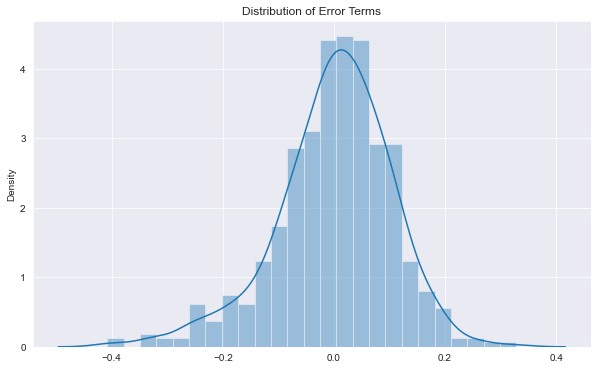

In [49]:
plt.figure(figsize = (10, 6))
sns.set_style("darkgrid")
sns.distplot(error)
plt.title('Distribution of Error Terms')
plt.show()

We can see Error Terms are normally Distributed with mean Zero. Hence Model is Actaully obeying the assumption of Normality

***8.3 - Homoscedasticity***

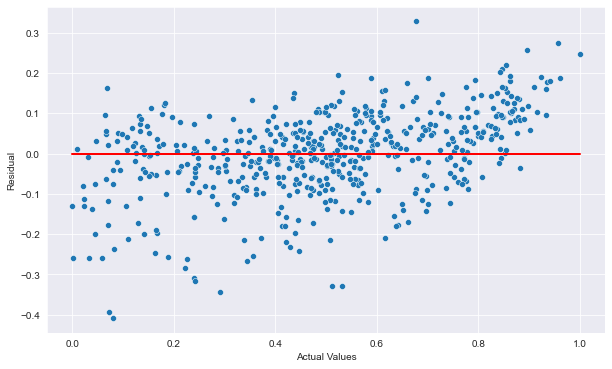

In [50]:
plt.figure(figsize = (10, 6))
sns.set_style("darkgrid")
sns.scatterplot(y_train, error)
plt.plot(y_train, (y_train - y_train), '-r')
plt.xlabel('Actual Values')
plt.ylabel('Residual')
plt.show()

We can see there is no specific Pattern observed in the Error Terms, hence we can say Error terms are independent of each other

***8.4 - Independence of residuals***

Autocorrelation occurs when the residuals are not independent of each other. To verify that the observations are not auto-correlated, we can use the Durbin-Watson test. The value of the test statistic lies between 0 and 4. The closer it is to 2, the less auto-correlation there is between the various variables
- 0 – 2: positive auto-correlation
- 2 – 4: negative auto-correlation

*From the Model Summary the Durbin-Watson value for model lr3 is `2.016`*

***8.5 - Absence of Multicollinearity***

<AxesSubplot:>

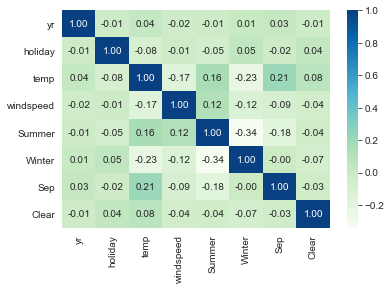

In [51]:
sns.heatmap(x_train_rfe.corr(), annot=True, fmt='.2f', cmap='GnBu') 

From the above heatmap we can say there is no corelation between the features and we saw that VIF values for all the features were below 5

### 9. Making Predictions Using the Final Model

In [52]:
# Scaling the test data because its trained on scaled data only
numeric_vars = ['temp','atemp','hum','windspeed','cnt']
data_test[numeric_vars] = scaler.transform(data_test[numeric_vars])

In [53]:
data_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Fall,Summer,...,Oct,Sep,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,Clear,Mist
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,...,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.00000
mean,0.448087,0.027322,0.710383,0.522587,0.496471,0.623725,0.445953,0.476973,0.240437,0.251366,...,0.065574,0.065574,0.174863,0.131148,0.147541,0.131148,0.163934,0.136612,0.661202,0.31694
std,0.498662,0.163468,0.454829,0.231179,0.218059,0.147591,0.216902,0.231726,0.428521,0.434989,...,0.248215,0.248215,0.380892,0.338488,0.355617,0.338488,0.371232,0.344380,0.474600,0.46656
min,0.000000,0.000000,0.000000,0.047675,0.051010,0.193646,0.062325,-0.049378,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.319255,0.311788,0.518762,0.283505,0.278884,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,1.000000,0.498465,0.490358,0.607986,0.426778,0.477967,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
75%,1.000000,0.000000,1.000000,0.728577,0.688345,0.717689,0.541285,0.644151,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,0.965734,0.939531,1.002146,1.214955,0.980804,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [54]:
# Splitting the data 
y_test = data_test.pop('cnt')
x_test = data_test

In [55]:
# Getting the columns
model_col = x_train_rfe.columns
x_test=x_test[model_col]
x_test_lm = sm.add_constant(x_test)
x_test_lm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 468 to 294
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   const      183 non-null    float64
 1   yr         183 non-null    int64  
 2   holiday    183 non-null    int64  
 3   temp       183 non-null    float64
 4   windspeed  183 non-null    float64
 5   Summer     183 non-null    uint8  
 6   Winter     183 non-null    uint8  
 7   Sep        183 non-null    uint8  
 8   Clear      183 non-null    uint8  
dtypes: float64(3), int64(2), uint8(4)
memory usage: 9.3 KB


In [56]:
# Making predictions on test set
y_test_pred = lr.predict(x_test_lm)

### 10. Model Evaluation

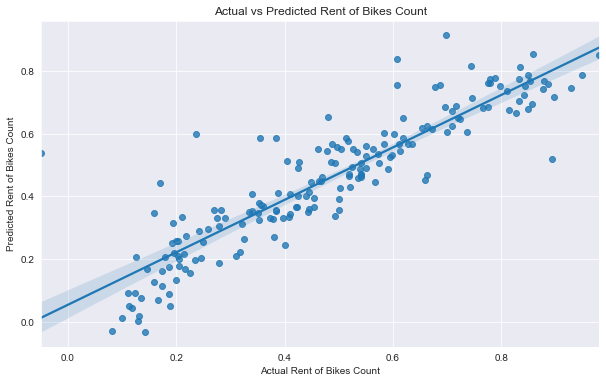

In [57]:
# Plotting y_test and y_test_pred to understand the spread.
plt.figure(figsize = (10,6))
sns.set_style("darkgrid")
sns.regplot(y_test, y_test_pred)
plt.title('Actual vs Predicted Rent of Bikes Count')
plt.xlabel('Actual Rent of Bikes Count')
plt.ylabel('Predicted Rent of Bikes Count')
plt.show()

In the above Scatter plot it shows the linear relationship between Actual Count and Predicted Count and the spread is very minimal

In [58]:
# Checking the R2 Score of the model for both test & train
print('Train set ->', round(r2_score(y_train, y_train_pred), 4))
print('Test set ->', round(r2_score(y_test, y_test_pred), 4))

Train set -> 0.8027
Test set -> 0.7916


### The equation of best fitted surface based on model:

*cnt = (0.248378 x yr) - (0.088947 x holiday) + (0.597752 x temp) − (0.114347 x windspeed) + (0.099411 x Summer) + (0.143651 x Winter) + (0.105782 x Sep) + (0.096208 x Clear) - 0.042015*

### Top 5 predictor variables that influences bike booking are:
- Temperature
- Year
- Winter
- September
- Summer

### Insights:
- Temperature is the Most Significant Feature which affects the Business positively
- Other Environmental condition such as Raining, Humidity, Windspeed and Cloudy affects the Business negatively.
- The Demand of Bikes is more in the Winter and Summer season, mostly user don't like to travel using Bikes in Rainy Season. 
- Most of the people rent the bikes in September.
- Most of the people use bikes on Saturday more than other usual days
- Holidays have negative impact on the rentals
- Demand of Bike Rent has been significantly increased in the 2019 than 2018